In this notebook we consider the estimation of the distribution of the confusion matrix

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed

from mmur.simulators import lalgorithm
# from blob_generator import BlobGenerator

ModuleNotFoundError: No module named 'mmur.simulators'

Assumed is a Gaussian distribution for both classes. Dataset consists of two Gaussian blobs, with tunable covariance between the features

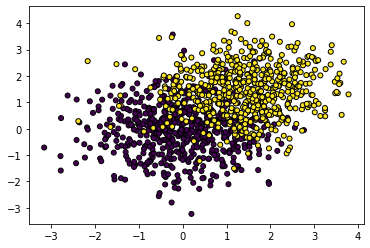

In [2]:
generator = BlobGenerator(
        train_size = 1000,
        test_size = 200,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        n_clusters_per_class=1,
        weights=[0.5,0.5],
        flip_y=0,
        class_d=2.0,
        scale=1.0,
        shuffle=False,
        random_state=123,
        var = 1,
        cov = 0,
        random_imbalance=False)
X,y = generator.make_classification()

generator.plot_blobs(X,y,scatter = True,contour=False)

First, we simulate the true confusion matrix distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size.
This is the same as the true distribution of the holdout estimator. From this we can also derive the true distributions of the performance metrics.

Several components are added to resemble noise present in a practical setting. 

<b>random_imbalance</b>: given the class balance set by weights, the number observations with a certain label is sampled from a binomial distribution (multinomial for n_classes>2)

<b>flip_y</b>: fraction of observations that is susceptible to being flipped. If an observation is susceptible it takes any of the labels with equal probability

<b>fix_init</b>: fixes the seed for the learning algorithm

In [3]:
def sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, nd_train, imbalance_prior_frac = None, n_runs = 1000, gen_seed=123):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        imbalance_prior_frac=imbalance_prior_frac,
        random_state=gen_seed,
        )

    LA = LAlgorithm(
        model_name,
        generator,
        nd_train=nd_train
        )
        #random state to be added here

    cms = LA.sim_true_cms(n_runs)
    precs = LA.cms_to_precision(cms)
    return precs

def create_and_plot(train_size, test_size, weights, flip_y, random_imbalance, contour = True, scatter=True):
    generator = BlobGenerator(
            train_size,
            test_size=test_size,
            weights=weights,
            flip_y=flip_y,
            random_imbalance=random_imbalance,
            random_state=123,
            )
    X,y = generator.make_classification()
    generator.plot_blobs(X,y,contour=contour,scatter=scatter)

#### 1. Looking at the effect of sampling noise for the train and test set separately

In [4]:
#First consider the scenario with the least amount of uncertainty. We have a very large train and test set

train_size = int(1e6)
test_size = int(1e6)
weights = [0.8,0.2]
random_imbalance = False
flip_y = 0
model_name = 'LR'
fix_init = True
n_runs = 100

# create_and_plot(10000, 10, weights, flip_y, random_imbalance,contour = False)
precs0 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   17.3s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   44.6s finished


In [5]:
print("Mean precision of: ",np.round(np.mean(precs0),decimals=3))
print("Std of: ",np.round(np.std(precs0),decimals=3))

#We observe that the precision converges to 0.774 for large train and test sets

Mean precision of:  0.774
Std of:  0.001


In [30]:
#Large train set -- looking at variance solely due to medium test set sample

train_size = int(1e6)
test_size = 1000
n_runs = 5000

# create_and_plot(1, test_size, weights, flip_y, random_imbalance,contour = False)
precs1 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    6.7s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:   37.3s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:  1.5min
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:  2.6min
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:  4.1min
[Parallel(n_jobs=15)]: Done 1770 tasks      | elapsed:  5.9min
[Parallel(n_jobs=15)]: Done 2420 tasks      | elapsed:  8.1min
[Parallel(n_jobs=15)]: Done 3170 tasks      | elapsed: 10.2min
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed: 12.5min
[Parallel(n_jobs=15)]: Done 4970 tasks      | elapsed: 15.2min
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed: 15.2min finished


In [31]:
#Large train set -- looking at variance solely due to small test set sample

train_size = int(1e6)
test_size = 100

# create_and_plot(1, test_size, weights, flip_y, random_imbalance,contour = False)
precs1_1 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    5.2s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:   31.4s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:  1.2min
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:  2.2min
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:  3.4min
[Parallel(n_jobs=15)]: Done 1770 tasks      | elapsed:  4.9min
[Parallel(n_jobs=15)]: Done 2420 tasks      | elapsed:  6.7min
[Parallel(n_jobs=15)]: Done 3170 tasks      | elapsed:  8.7min
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed: 11.0min
[Parallel(n_jobs=15)]: Done 4970 tasks      | elapsed: 13.6min
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed: 13.7min finished


In [32]:
#Large test set -- looking at variance solely due to medium train set sample

train_size = 5000
test_size = int(1e6)
precs2 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    2.0s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:   12.1s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   28.9s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   52.1s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:  1.4min
[Parallel(n_jobs=15)]: Done 1770 tasks      | elapsed:  2.0min
[Parallel(n_jobs=15)]: Done 2420 tasks      | elapsed:  2.7min
[Parallel(n_jobs=15)]: Done 3170 tasks      | elapsed:  3.6min
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed:  4.5min
[Parallel(n_jobs=15)]: Done 4970 tasks      | elapsed: 66.7min
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed: 66.8min finished


In [33]:
#Large test set -- looking at variance solely due to small train set sample

train_size = 500
test_size = int(1e6)
precs2_1 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:   16.6s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   43.8s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:  1.2min
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:  1.7min
[Parallel(n_jobs=15)]: Done 1770 tasks      | elapsed:  2.3min
[Parallel(n_jobs=15)]: Done 2420 tasks      | elapsed:  3.0min
[Parallel(n_jobs=15)]: Done 3170 tasks      | elapsed:  3.9min
[Parallel(n_jobs=15)]: Done 4020 tasks      | elapsed:  4.9min
[Parallel(n_jobs=15)]: Done 4970 tasks      | elapsed:  5.9min
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:  6.0min finished
c:\Users\coenv\Documents\internship\ING\Thesis\code\ModelMetricUncertaintyResearch\mmur\generators\algorithms.py:233: RuntimeWarning: invalid value encountered in true_divide
  return TP/(TP+FP)


In [10]:
#medium train and test sets -- combined uncertainty
n_runs = 5000

train_size = 5000
test_size = 1000
precs3 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 670 tasks      | elapsed:    1.5s
[Parallel(n_jobs=15)]: Done 2670 tasks      | elapsed:    4.5s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    7.4s finished


In [11]:
#Small train and test sets -- combined uncertainty

train_size = 500
test_size = 100
precs3_1 = sim_precisions(train_size, test_size, weights, random_imbalance, flip_y, model_name, fix_init, n_runs = n_runs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 830 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 4680 tasks      | elapsed:    3.5s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    3.7s finished


<AxesSubplot:>

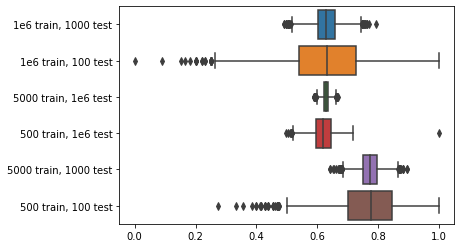

In [34]:
df = pd.DataFrame({'1e6 train, 1000 test' : precs1,'1e6 train, 100 test' : precs1_1, '5000 train, 1e6 test' : precs2, '500 train, 1e6 test' : precs2_1,
 '5000 train, 1000 test' : precs3,'500 train, 100 test' : precs3_1})
# df = pd.DataFrame({'Large train, small test' : precs1, 'Small train, small test' : precs3})
# sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True)
# sns.displot(df,kind = 'kde',common_norm = True)

sns.boxplot(data=df,orient='h')


#The test set appears to contribute to the variance most (for logistic regression). Interestingly, a limited size of the train set does not 
#seem to contribute much to the variance of the precision.

#### 2. Simulate precision distribution with sampling noise and stochastic class balance

In [12]:
# Function to simulate the observed balances
# The class balance is determined by the sample size, mean balance defined by weights, 
# and another weighing term "imbalance_prior_frac" to inflate/deflate variance.

def sim_random_balance(generator, imbalance_prior_frac, n_runs = 100):
    generator.imbalance_prior_frac = imbalance_prior_frac
    bal = []
    for _ in range(n_runs):
        X,y = generator.make_classification()
        bal.append(np.mean(y))
    return bal

Text(0.5, 1.0, 'Class balance distribution for different prior weighing factors')

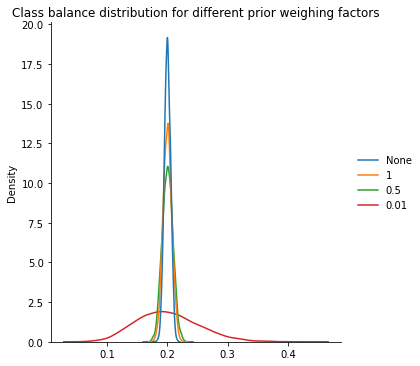

In [14]:
# Simulating the class balance distribution

train_size = 5000
test_size = 1000
weights = [0.8,0.2]
flip_y = 0
model_name = 'LR'
nd_train = False
n_runs = 5000

random_imbalance = True
random_state = 123

generator = BlobGenerator(
            train_size=train_size,
            test_size=test_size,
            weights=weights,
            flip_y=flip_y,
            random_imbalance = random_imbalance,
            random_state=random_state)

balance_distr = {}
for imbalance_prior_frac in [None,1,0.5,0.01]:
    balance_distr[str(imbalance_prior_frac)] = sim_random_balance(generator,imbalance_prior_frac,n_runs = n_runs)
sns.displot(pd.DataFrame(balance_distr),kind='kde',common_norm = True)
plt.title('Class balance distribution for different prior weighing factors')

In [15]:
imbalance_prior_frac = None
precs4 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=1)
    
imbalance_prior_frac = 1
precs4_1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=2)

imbalance_prior_frac = 0.1
precs4_2 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=3)

imbalance_prior_frac = 0.01
precs4_3 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=3)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 670 tasks      | elapsed:    1.4s
[Parallel(n_jobs=15)]: Done 2670 tasks      | elapsed:    4.4s
[Parallel(n_jobs=15)]: Done 4971 out of 5000 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    7.4s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 850 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done 2850 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    6.4s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 1250 tasks      | elapsed:    1.5s
[Parallel(n_jobs=15)]: Done 4740 tasks   

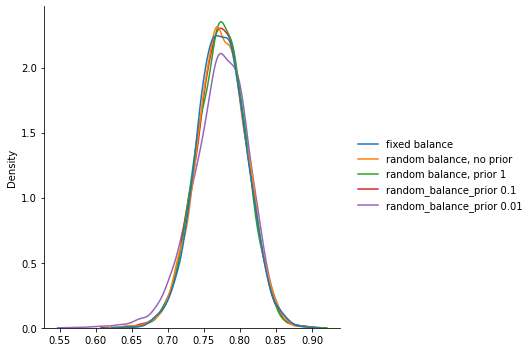

In [17]:

# df = pd.DataFrame({'no random balance' : precs3, 'with random balance' : precs4})
df = pd.DataFrame({'fixed balance':precs3,'random balance, no prior' : precs4, 'random balance, prior 1' : precs4_1,'random_balance_prior 0.1':precs4_2, 
    'random_balance_prior 0.01':precs4_3})
# sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True)
sns.displot(df,kind = 'kde')

#does not appear to make a difference for train_size=5000, perhaps for lower sample sizes? (fixed test size)

<AxesSubplot:>

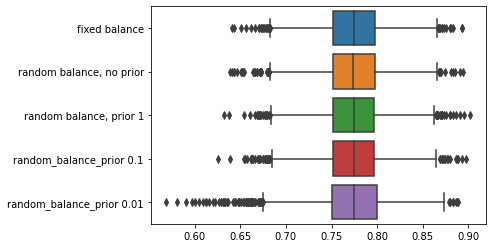

In [18]:
sns.boxplot(data=df,orient='h')

In [22]:
train_size = 500
test_size = 100

random_imbalance = True
imbalance_prior_frac = None

precs5 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=4)

imbalance_prior_frac = 0.1
precs5_1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=4)
#Not really a clear difference in distribution (specifically variance) still, precisions can vary a tiny bit

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 830 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 4680 tasks      | elapsed:    3.5s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    3.7s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 1250 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done 4710 tasks      | elapsed:    3.3s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    3.6s finished


<AxesSubplot:>

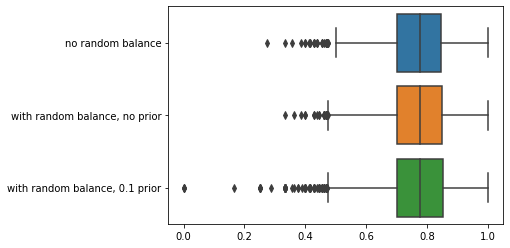

In [23]:
n_precs = np.min([len(precs3_1),len(precs5),len(precs5_1)])

df = pd.DataFrame({'no random balance' : precs3_1[:n_precs], 'with random balance, no prior' : precs5[:n_precs], 
    'with random balance, 0.1 prior':precs5_1})
# sns.displot(df,kind = 'kde')
sns.boxplot(data=df,orient='h')

#### 3. Introducing label noise to the data. What is the effect on the distribution of the precision?

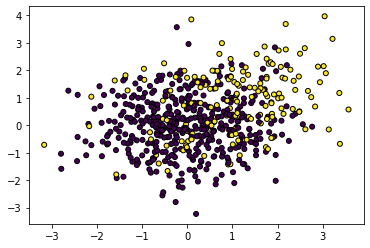

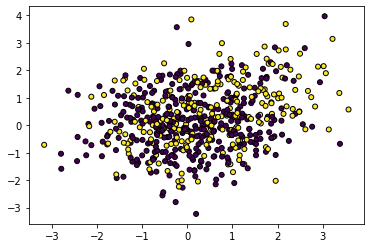

In [26]:
generator = BlobGenerator(
        train_size,
        test_size,
        weights=weights,
        flip_y=0.1,
        class_d=2.0,
        random_state=123,
        random_imbalance=False)
X,y = generator.make_classification()
generator.plot_blobs(X,y,scatter = True,contour=False)
# plt.title('flip probabilibity = 0.1')

generator = BlobGenerator(
        train_size,
        test_size,
        weights=weights,
        flip_y=0.3,
        class_d=2.0,
        random_state=123,
        random_imbalance=False)
X,y = generator.make_classification()
generator.plot_blobs(X,y,scatter = True,contour=False)
# plt.title('flip probabilibity = 0.3')

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    6.1s
[Parallel(n_jobs=15)]: Done 430 tasks      | elapsed:    6.7s
[Parallel(n_jobs=15)]: Done 4350 tasks      | elapsed:   10.5s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:   11.3s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 1250 tasks      | elapsed:    1.2s
[Parallel(n_jobs=15)]: Done 4755 tasks      | elapsed:    3.9s
[Parallel(n_jobs=15)]: Done 5000 out of 5000 | elapsed:    4.2s finished


  Flip probability    std
0                0  0.034
1              0.1  0.037
2              0.3  0.044


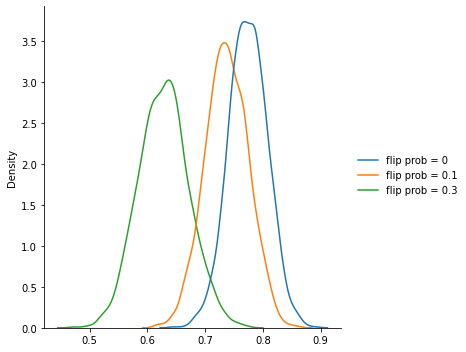

In [27]:
train_size = 5000
test_size = 1000
random_imbalance = False

flip_y = 0.1
precs5 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=5)

flip_y = 0.3
precs5_1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=6)
    
n_precs = np.min([len(precs3),len(precs5),len(precs5_1)])

df = pd.DataFrame({'flip prob = 0':precs3[:n_precs],'flip prob = 0.1' : precs5[:n_precs], 'flip prob = 0.3' : precs5_1[:n_precs]})
# sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True) #type = kde
sns.displot(df,kind='kde') #type = kde

#We observe that the mean precision decreases.
df = pd.DataFrame([['0','0.1','0.3'],[np.round(np.std(x),decimals=3) for x in [precs3,precs5,precs5_1]]]).T
df.columns = ['Flip probability','std']
print(df)

#we observe that the standard deviation of the precision increases with higher flip probability

#### All noise components combined, comparison

In [ ]:
train_size = 5000
test_size = 1000
weights = [0.8,0.2]
flip_y = 0.1
model_name = 'LR'
nd_train = False
n_runs = 5000

random_imbalance = True
random_state = 123

precs_7 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,nd_train,imbalance_prior_frac = imbalance_prior_frac, 
    n_runs = n_runs,gen_seed=5)

Comparison for different types of noise

In [29]:
df = pd.DataFrame({'1e6 train, 1000 test' : precs1, '5000 train, 1e6 test' : precs2, '5000 train, 1000 test' : precs3,
    'Random class balance': precs4, 'label noise, flip proba=0.1':precs5})
sns.boxplot(data = df, orient = 'h')

ValueError: arrays must all be same length

#### 4. Consider now two models with non-deterministic training: XGBoost and a neural net (MLP), what is the distribution of the precision on a single dataset due to non-deterministic training?

In [36]:
import algorithms
from importlib import reload
reload(algorithms)
from algorithms import LAlgorithm

train_size = 5000
test_size = 1000
weights = [0.8,0.2]
flip_y = 0
random_imbalance = False
n_runs = 10
fix_init = False

In [37]:
def sim_nd_train_prec(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, tau=0.5, parallel=False):
        generator = BlobGenerator(
                train_size,
                test_size=test_size,
                weights=weights,
                flip_y=flip_y,
                random_imbalance=random_imbalance,
                random_state=gen_seed,
                )
        LA = LAlgorithm(model_name,generator,fix_init=fix_init)
        cms = LA.repeat_nd_train(n_runs,data_seed = gen_seed,tau=tau,parallel=parallel)
        precs = LA.cms_to_precision(cms)
        return precs

In [39]:
train_size = 5000
test_size = 1000
weights = [0.8,0.2]
flip_y = 0
random_imbalance = False
n_runs = 100
fix_init = False

model_name = 'NN'
gen_seed = 12

precs_NN = sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=True)
# sns.displot(precs_NN,binwidth = 0.02)

#distribution NN performance given a fixed dataset is quite wide

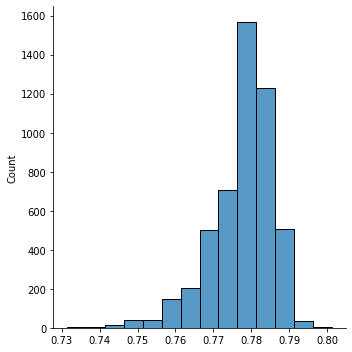

In [43]:
sns.displot(precs_NN,binwidth = 0.005)

In [40]:
model_name = 'XGB'
gen_seed = 12
precs_GB = sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=True)

model_name = 'LR'
precs_LR = sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=True)
# sns.displot(precs_GB)

#minimal differences with Gradient Boosting

,XGBoost,Logistic Regression
0,0.751445,0.77095
1,0.751445,0.77095
2,0.751445,0.77095
3,0.751445,0.77095
4,0.751445,0.77095
5,0.751445,0.77095
6,0.751445,0.77095
7,0.751445,0.77095
8,0.751445,0.77095
9,0.751445,0.77095


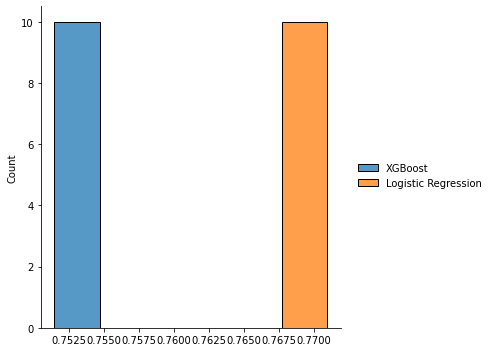

In [41]:
df = pd.DataFrame({'XGBoost':precs_GB, 'Logistic Regression':precs_LR})
sns.displot(df)
df

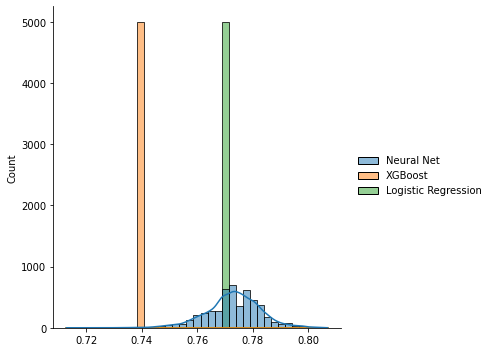

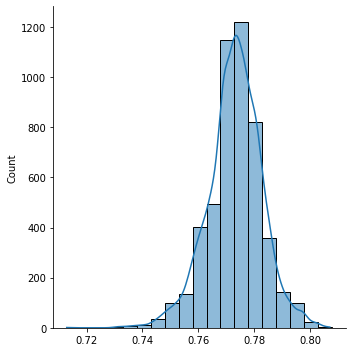

In [ ]:
df = pd.DataFrame({'Neural Net': precs_NN,'XGBoost':precs_GB, 'Logistic Regression':precs_LR})
sns.displot(df,kde = True)
sns.displot(precs_NN,kde = True,binwidth = 0.005)

In [ ]:
sns.boxplot(df)

#### Investigating the differences in variance for a NN depending on data sample

In [23]:
def sim_var_prec_nd(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,n_sets,tau=0.5,parallel=False):
    generator = BlobGenerator(
                train_size,
                test_size=test_size,
                weights=weights,
                flip_y=flip_y,
                random_imbalance=random_imbalance,
                random_state=gen_seed,
                )
    LA = LAlgorithm(model_name,generator,fix_init=fix_init)
    stds = LA.sim_prec_std(n_sets,n_runs,parallel=parallel)
    return stds

def sim_iv_prec_nd(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, n_sets, qrange=0.95, tau=0.5, parallel=False):
    generator = BlobGenerator(
                train_size,
                test_size=test_size,
                weights=weights,
                flip_y=flip_y,
                random_imbalance=random_imbalance,
                random_state=gen_seed,
                )
    LA = LAlgorithm(model_name,generator,fix_init=fix_init)
    iv_lens = LA.sim_prec_iv(n_sets, n_runs, qrange, parallel, n_jobs=15)
    return iv_lens

In [24]:
train_size = 5000
test_size = 1000
weights = [0.8,0.2]
n_runs = 100
n_sets = 100
flip_y = 0
random_imbalance = False
fix_init = False
model_name = 'NN'
gen_seed = 12

iv_lens = sim_iv_prec_nd(
    train_size, 
    test_size, 
    weights, 
    flip_y, 
    random_imbalance, 
    gen_seed, 
    model_name, 
    fix_init, 
    n_runs, 
    n_sets, 
    qrange=0.95, 
    tau=0.5, 
    parallel=True)

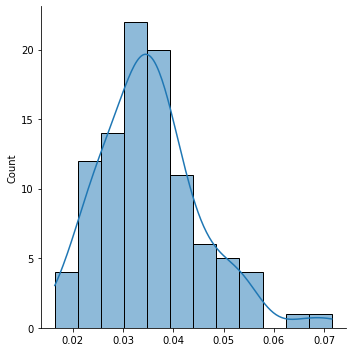

In [25]:
sns.displot(iv_lens, kde = True)

#### To be continued

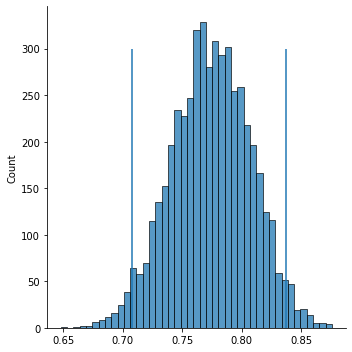

In [47]:
# np.quantile(precs0,0.9)
# sns.displot(precs1)
# plt.vlines([np.quantile(precs1,0.025),np.quantile(precs1,0.975)],ymin=0,ymax=300)

In [62]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator
# train_size = 1000
# test_frac = 1/5
# weights = [0.8,0.2]
# n_sets = 100
# random_imbalance = False
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 10

# def simulate_cms(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,random_state,train_seed=0):
#     data_dict = f.generate_blobs(train_size = train_size,test_size=int(test_frac*train_size),n_sets=n_sets,
#                                 random_state = random_state,flip_y=flip_y,weights = weights,random_imbalance=random_imbalance)
#     return f.holdout_CM(model_name,data_dict,train_seed,fix_init=fix_init)

# cms = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# # precisions
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recalls
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

Here I experiment with different weight splits, to observe the effect on 3 models: Logistic regression, neural network and Gradient Boosting

In [144]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator

# def flatten(t):
#     return [item for sublist in t for item in sublist]

# def simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats):
#     precs_list = []
#     recs_list = []
#     col_model = []
#     col_balance = []
    
#     for model_name in model_names:
#         for w in weight_splits:
#             weights = [1-w,w]
#             cms = np.vstack(Parallel(n_jobs=-1,verbose = 1)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#                 fix_init,random_state=seed_i) for seed_i in range(repeats)))

#             # precisions
#             TP = cms[:,1,1]
#             FP = cms[:,0,1]
#             precs = TP/(TP+FP)

#             #recalls
#             FN = cms[:,1,0]
#             recs = TP/(TP+FN)
#             precs_list.append(precs.tolist())
#             recs_list.append(recs.tolist())
#             col_model.append(np.repeat(model_name,n_sets*repeats).tolist())
#             col_balance.append(np.repeat(w,n_sets*repeats).tolist())
#     results = {'precision': flatten(precs_list), 'recall':flatten(recs_list),'model':flatten(col_model),'balance':flatten(col_balance)}
#     return results

In [173]:
# model_names = ['LR','NN','GB']
# # weight_splits = [0.1,0.3,0.5]
# train_sizes = [100,200,300]

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True
# # flip_y = 0
# fix_init = True
# repeats = 1000

# for flip_y in [0.05,0.1,0.2]:

#     filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
#     plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

#     results = simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats)

#     pd.DataFrame(results).to_csv(plot_dir + filename +'.csv')

First consider only the noise introduced due to random class balance. First we fix the (mean) balance at 0.3, and set the train size at 1000. Consider a Logistic Regression model

In [61]:
# train_size = 500
# test_frac = 1/5
# weights = [0.7,0.3]
# n_sets = 1
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 1000

# random_imbalance = False
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# random_imbalance = True
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

In [172]:
# plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = False
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_0 = pd.read_csv(plot_dir + filename +'.csv')

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True #random imbalance included
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_1 = pd.read_csv(plot_dir + filename +'.csv')

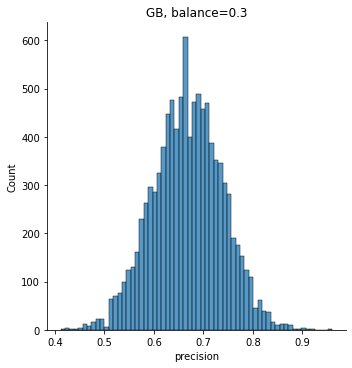

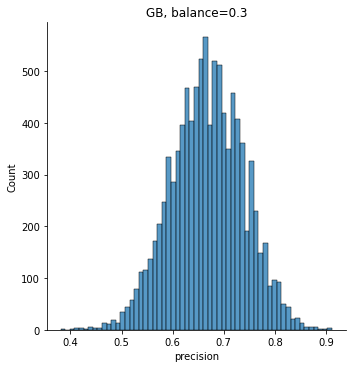

In [171]:
# # df_0 = pd.DataFrame(results)
# # sns.displot(df_0,x = 'precision',hue = 'model',col = 'balance',kde=True)
# # df_0.to_csv('results0.csv')
# # df
# def make_plot(df,model,balance,metric='precision'):
#     df_slice = df[(df['balance']==balance)& (df['model']==model)]
#     sns.displot(data=df_slice,x=metric)
#     plt.title(' '.join([model + ',','balance=' + str(balance)]))
# # sns.displot(data = df_0[(df_0['balance']==0.3)&(df_0['model']=='LR')],x = 'precision')
# # plt.title(' '.join(['LR,','balance=' + str(0.3)]))

# # make_plot(df_0,'LR',0.1,metric='recall')
# make_plot(df_0,'GB',0.3,metric='precision')
# make_plot(df_1,'GB',0.3,metric='precision')
# # make_plot(df_0,'LR',0.5,metric='recall')

In [84]:
# pd.DataFrame(np.array(precs_list).T)
# np.array(precs_list).flatten().shape
# col_model = np.repeat(model_names,repeats*n_sets*len(weight_splits)).shape
# col_balance = 
# # cms.shape

(600,)

In [6]:
# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# H, xedges, yedges= np.histogram2d(precs,recs)



# xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = H.ravel()

# cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
# max_height = np.max(dz)   # get range of colorbars so we can normalize
# min_height = np.min(dz)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap((k-min_height)/max_height) for k in dz] 

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color = rgba)

# plt.show()

Retrieving the true precisions and recalls

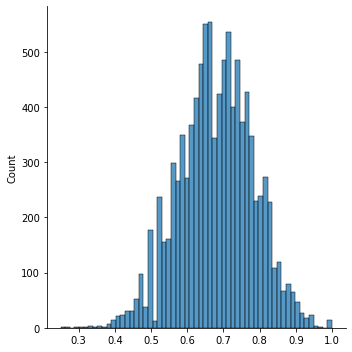

In [19]:
# # precs
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recs
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

# sns.displot(precs)

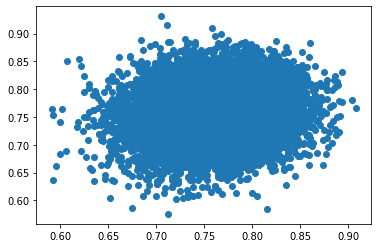

In [8]:
# plt.scatter(precs,recs)

Method by Caelen (2017), multinomial likelihood with Dirichlet priors

In [28]:
# #Given an observed CM, compute the distribution of a performance metric by MC-sampling
# from numpy.random import default_rng

# theta_prior = np.ones(4)
# rng = default_rng(0)
# cm = cms[0]

# def sample_CM(v,theta_prior):
#     theta_post = rng.dirichlet(alpha = v + theta_prior)
#     cm = rng.multinomial(n = v.sum(), pvals = theta_post)
#     return cm.tolist()

# def sample_CM_N(v,theta_prior,MC_N=1000):
#     CL_cms = np.zeros((MC_N,4),dtype = int)
#     for i in range(MC_N):
#         CL_cms[i] = sample_CM(v,theta_prior)
#     return CL_cms

# def prec_from_CMs(cms):
#     TP = cms[:,-1]
#     FP = cms[:,1]
#     return TP/(TP+FP)

# def rec_from_CMs(cms):
#     TP = cms[:,-1]
#     FN = cms[:,-2]
#     return TP/(TP+FN)


In [37]:
# cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
# Cae_precs = []

# for cm in cms[:3]:
#     cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
#     Cae_precs.append(prec_from_CMs(cms_CA))

C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of precision')

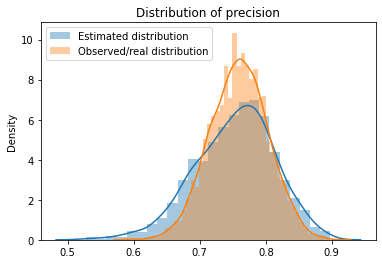

In [47]:
# sns.distplot(Cae_precs[2], label = 'Estimated distribution')
# sns.distplot(precs, label = 'Observed/real distribution')
# plt.legend()
# plt.title('Distribution of precision')

# #TODO: Calculate the coverage and size of confidence intervals created by Caelen's method

In [9]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix

# def CM_cv(X,y,test_frac,model_name,seed=0,fix_train = False):
#     kf = KFold(n_splits = int(1/test_frac)+1)
#     LA = LAlgorithm(model_name)
#     cms = []
#     for train_index, test_index in kf.split(X):
#         if not fix_train:
#             seed+=1
#         model = LA.init_model(random_state = seed) #initialize model
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         model.fit(X_train,y_train)
#         y_pred = model.predict(X_test)
#         cms.append(confusion_matrix(y_test,y_pred).tolist())
#     return cms

In [10]:
# data_dict = f.generate_blobs(train_size = 1000,test_size=200,n_sets=n_sets,random_state = 1,flip_y=0.1)
# X,y = f.unpack_data_dict(data_dict,stack = True)
# cms_cv = CM_cv(X[0],y[0],test_frac,model_name)
# np.array(cms_cv)

array([[[81, 19],
        [37, 63]],

       [[73, 22],
        [31, 74]],

       [[67, 32],
        [27, 74]],

       [[77, 28],
        [17, 78]],

       [[78, 35],
        [28, 59]],

       [[68, 27],
        [31, 74]]])

In [66]:
# CM_cv(X_train[0],y,test_frac,seed,model_name,fix_train = False)

(1000, 1000, 2)

Firstly, consider the case where we have only a single train-test run. This is equivalent to a holdout estimator. 
To obtain a confidence interval we need to evaluate the variance of this estimator. 

This can be done by:
1.  assuming a binomial distribution on the precision/recall and using a normal approximation for the confidence interval

In [6]:
# # %% To obtain a confidence interval of the expected precision we need to evaluate the variance of the holdout estimator. This can be done by assuming
# #a binomial distribution and using a normal approximation for the confidence interval
# n_pos = out[:,2,:].flatten()

# l = true_precs - 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)
# u = true_precs + 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)

# #fraction of confidence intervals that cover the true population parameter value
# print(np.mean((l<EP_prec) & (EP_prec<u)))

# #We observe that the confidence interval is approximately correct, it covers the true mean in about 94 percent of the cases.

# #Save the widths to compare with the other methods
# holdout_CI_width = u-l

0.9378


2. bootstrapping both train and test

In [56]:
# from numpy.random import default_rng

# def bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False):
#     rng = default_rng(seed)

#     X_train = data_dict['train']['X']
#     y_train = data_dict['train']['y']
#     X_test = data_dict['test']['X']
#     y_test = data_dict['test']['y']

#     X = np.hstack([X_train, X_test])
#     y = np.hstack([y_train, y_test])

#     n_obs = y.shape[1]
#     bs_indices = rng.integers(0,high = n_obs,size = y.shape)

#     X_bs = np.zeros(X.shape)
#     y_bs = np.zeros(y.shape)

#     for i in range(len(y_bs)):
#         X_bs[i] = X[i][bs_indices[i]]
#         y_bs[i] = y[i][bs_indices[i]]

#     train_size = y_train.shape[1]

#     X_train = X_bs[:,:train_size,:]
#     X_test = X_bs[:,train_size:,:]
#     y_train = y_bs[:,:train_size,:]
#     y_test = y_bs[:,train_size:,:]

#     return X_train,X_test,y_train,y_test


# def bootstrap_prec_rec(learn_algo,data_dict,seed=0,fix_init=False):
#     X_train,X_test,y_train,y_test = bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False)

#     if fix_init:
#         train_seed = 0
#     else:
#         train_seed = seed
#     LA = LAlgorithm(learn_algo)

#     precs = []
#     recs = []
#     n_pos = []
#     for i in range(len(y_train)):
#         model = LA.init_model(random_state=train_seed+i)
#         model.fit(X_train[i],y_train[i])
#         y_pred = model.predict(X_test[i]) 

#         n_pos.append(np.sum(y_pred==1))
#         precs.append(precision_score(y_test[i],y_pred))
#         recs.append(recall_score(y_test[i],y_pred))



IndentationError: expected an indented block (4180208275.py, line 39)

In [52]:


# rng = default_rng(1)
# n_obs = train_size + int(train_size * test_frac)
# data_dict['train']['y'][0]
# data_dict['train']['X']
# bs_indices = rng.integers(0,high = n_obs,size = y.shape)

# X = np.hstack([data_dict['train']['X'], data_dict['test']['X']])
# y = np.hstack([data_dict['train']['y'], data_dict['test']['y']])

# bs_indices

# X_bs = np.zeros(X.shape)
# y_bs = np.zeros(y.shape)

# for i in range(len(y_bs)):
#     X_bs[i] = X[i][bs_indices[i]]
#     y_bs[i] = y[i][bs_indices[i]]


In [55]:
# bs_indices[0]

array([567, 614, 906, ..., 421, 304, 461], dtype=int64)

In [34]:
# data_dict['test']['X'][0].shape
# np.vstack([data_dict['train']['X'][0],data_dict['test']['X'][0]]).shape


(1200, 2)

3. We can use the Bayesian method by Caelen (2017); use a Multinomial likelihood for the confusion matrix and a Dirichlet prior on the probabilities

In [15]:
# cms = Parallel(n_jobs = -1,verbose = 5)(delayed(f.holdout_CM)(model_name,train_size,test_frac,n_sets=n_sets,seed=seed_i) for seed_i in range(repeats))
# cms = np.vstack(cms)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
